In [11]:
import os
import copy
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.backends.backend_pdf import PdfPages

def smooth(x, alpha=0.02):
    _mean = copy.deepcopy(x)
    _std = np.zeros_like(x)
    for i in range(1, len(x)):
        _mean[i] = (1 - alpha) * _mean[i-1] + alpha * _mean[i]
        _std[i] = (1 - alpha) * _std[i-1] + alpha * np.square(x[i] - _mean[i])
    return _mean, np.sqrt(_std)

def smooth_v2(x, window=10):
    _mean, _std = [], []
    for i in range(0, len(x), window):
        _mean.append(np.mean(x[i:i+window]))
        _std.append(np.std(x[i:i+window]))
    return np.array(_mean), np.array(_std)

def rolling_window(array, window=1000):
    '''
    apply a rolling window to a np.ndarray

    :param array: (np.ndarray) the input Array
    :param window: (int) length of the rolling window
    :return: (np.ndarray) rolling window on the input array
    '''
    shape = array.shape[:-1] + (array.shape[-1] - window + 1, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

def plot_one_line(y, y_std=None, color=None, label=None, 
                  smooth_rate=0.02, window=10, n=None, smooth_type=1):
    y = y[np.isfinite(y)]
    if y_std is None:
        if smooth_type == 1:
            y, y_std = smooth(y, smooth_rate)
        elif smooth_type == 2:
            y, y_std = smooth_v2(y, window)
    if n:
        y = y[:n]
        y_std = y_std[:n]
    x = np.arange(len(y))
    min_ = y - y_std
    max_ = y + y_std
    plt.fill_between(x, min_, max_, alpha=0.3, color=color)
    plt.plot(x, y, label=label, color=color)

def plot(*args, **kargs):
    assert 'column' in kargs.keys()
    kargs.setdefault(None)
    
    for i, arg in enumerate(args):
        assert isinstance(arg, dict) and 'path' in arg.keys(), arg
        csv = pd.read_csv(os.path.join(arg['path'], 'progress.csv'))
        plot_one_line(
            csv[kargs['column']].values, 
            color=arg.setdefault('color', f'C{i}'), 
            label=arg.setdefault('label', arg['path']),
            smooth_rate=kargs.setdefault('smooth_rate', 0.02),
            window=kargs.setdefault('window', 10),
            n=kargs.setdefault('episodes', None),
            smooth_type=kargs.setdefault('smooth', 1)
        )
        print('plotting', os.path.join(arg['path'], 'progress.csv'))
    
    if 'expert' in kargs.keys():
        plot_one_line(
            np.array([kargs['expert'].mean() for _ in range(1000)]), 
            np.array([kargs['expert'].std() for _ in range(1000)]),
            n=kargs.setdefault('episodes', None),
            label='expert',
            color='C1', 
        )
    
    plt.title(kargs.setdefault('title', kargs['column'])),
    plt.xlabel(kargs.setdefault('xlabel', 'episode')),
    plt.grid(color='white')
    plt.legend()
    for arg in args:
        plt.savefig(os.path.join(arg['path'], f'{kargs["column"]}.png'))
    plt.show()


plotting logs/PongNoFrameskip-v4/individual/progress.csv
plotting logs/PongNoFrameskip-v4/copier/progress.csv
plotting logs/PongNoFrameskip-v4/peer1_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot5_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot2_start2000/progress.csv


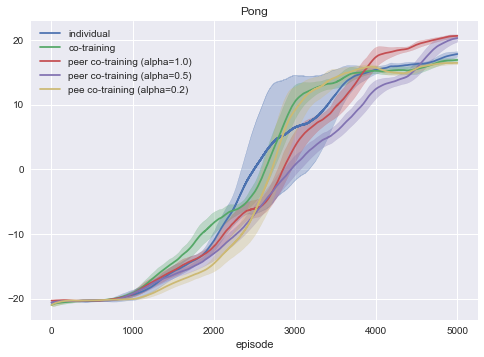

In [31]:
plot(
    {
        'path': 'logs/PongNoFrameskip-v4/individual/',
        'label': 'individual',
    }, {
        'path': 'logs/PongNoFrameskip-v4/copier/',
        'label': 'co-training',
    }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1',
    #     'label': 'Co-training (peer=1)',
    # }, {
#         'path': 'logs/PongNoFrameskip-v4/peer0dot5',
#         'label': 'Co-training (alpha=0.5)',
#     }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1_decay',
    #     'label': 'Co-training (peer=1, decay)',
    # }, {
        'path': 'logs/PongNoFrameskip-v4/peer1_start2000',
        'label': 'peer co-training (alpha=1.0)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot5_start2000',
        'label': 'peer co-training (alpha=0.5)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot2_start2000',
        'label': 'pee co-training (alpha=0.2)',
    },
    column='ep_reward_mean', title='Pong', episodes=5000,
    smooth=1, window=100, smooth_rate=0.01,
)


plotting logs/mount/BoxingNoFrameskip-v4/2e6steps_peer0/progress.csv
plotting logs/mount/BoxingNoFrameskip-v4/2e6steps_peer1/progress.csv


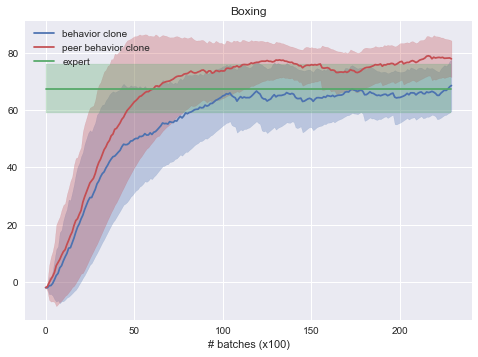

In [33]:
plot(
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/2e6steps_peer0/',
        'label': 'behavior clone',
    }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1',
    #     'label': 'Co-training (peer=1)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer0dot5',
    #     'label': 'Co-training (peer=0.5)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1_decay',
    #     'label': 'Co-training (peer=1, decay)',
    # }, {
        'path': 'logs/mount/BoxingNoFrameskip-v4/2e6steps_peer1',
        'label': 'peer behavior clone',
        'color': 'C2'
    },
    column='ep_reward_mean',
    window=50,
    xlabel='# batches (x100)',
    title='Boxing',
    episodes=230,
    smooth_rate=0.05,
    expert=np.load(
        'logs/mount/BoxingNoFrameskip-v4/baseline/2e6steps/expert.npz')['episode_returns']
)

plotting logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer0dot2/progress.csv


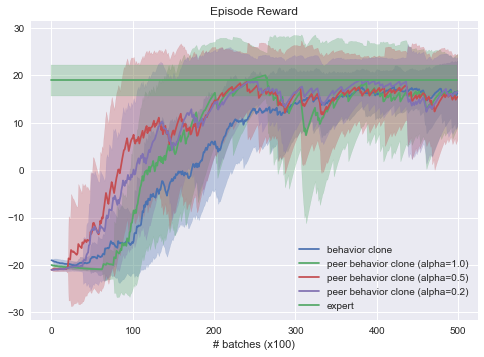

In [102]:
plot(
    {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/', 
        'label': 'behavior clone',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/',
        'label': 'peer behavior clone (alpha=1.0)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/',
        'label': 'peer behavior clone (alpha=0.5)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0dot2/',
        'label': 'peer behavior clone (alpha=0.2)',
    },
    column='ep_reward_mean', 
    title='Episode Reward',
    episodes=500,
    smooth_rate=0.05,
    xlabel='# batches (x100)',
    expert=np.load(
        'logs/PongNoFrameskip-v4/baseline/2000000_steps/expert.npz')['episode_returns']
)

plotting logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/progress.csv


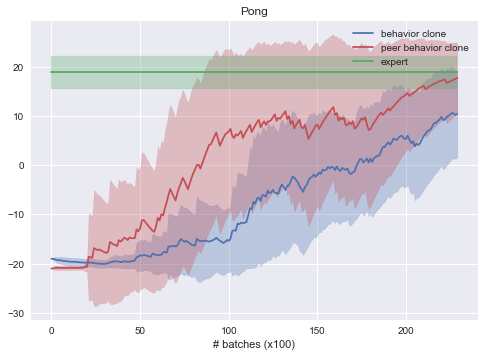

In [32]:
plot(
    {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/', 
        'label': 'behavior clone',
    }, {
#         'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/',
#         'label': 'peer behavior clone (alpha=1.0)',
#     }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/',
        'label': 'peer behavior clone',
        'color': 'C2'
    }, 
    column='ep_reward_mean', 
    title='Pong',
    episodes=230,
    smooth_rate=0.05,
    xlabel='# batches (x100)',
    expert=np.load(
        'logs/PongNoFrameskip-v4/baseline/2000000_steps/expert.npz')['episode_returns']
)

In [ ]:
plot(
    {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/', 
        'label': 'behavior clone',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/',
        'label': 'peer behavior clone (alpha=1.0)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/',
        'label': 'peer behavior clone (alpha=0.5)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/2000000_steps_peer0dot2/',
        'label': 'peer behavior clone (alpha=0.2)',
    },
    column='ep_reward_mean', xlabel='Episodes (x100)', title='Episode Reward',
    episodes=400,
)

plotting logs/PongNoFrameskip-v4/individual/progress.csv
plotting logs/PongNoFrameskip-v4/copier/progress.csv
plotting logs/PongNoFrameskip-v4/peer1_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot5_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot2_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer1_start2000_repeat10/progress.csv


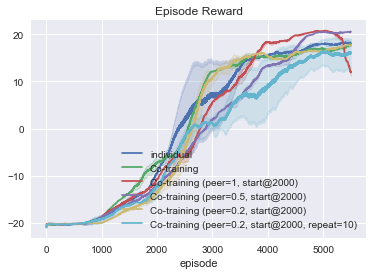

In [4]:
plot(
    {
        'path': 'logs/PongNoFrameskip-v4/individual/',
        'label': 'individual',
    }, {
        'path': 'logs/PongNoFrameskip-v4/copier/',
        'label': 'Co-training',
    }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1',
    #     'label': 'Co-training (peer=1)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer0dot5',
    #     'label': 'Co-training (peer=0.5)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1_decay',
    #     'label': 'Co-training (peer=1, decay)',
    # }, {
        'path': 'logs/PongNoFrameskip-v4/peer1_start2000',
        'label': 'Co-training (peer=1, start@2000)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot5_start2000',
        'label': 'Co-training (peer=0.5, start@2000)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot2_start2000',
        'label': 'Co-training (peer=0.2, start@2000)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer1_start2000_repeat10',
        'label': 'Co-training (peer=0.2, start@2000, repeat=10)',
    },
    column='ep_reward_mean', title='Episode Reward', episodes=5500,
    smooth_rate=0.1,
)


plotting logs/PongNoFrameskip-v4/copier/progress.csv
plotting logs/PongNoFrameskip-v4/peer1_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot5_start2000/progress.csv
plotting logs/PongNoFrameskip-v4/peer0dot2_start2000/progress.csv


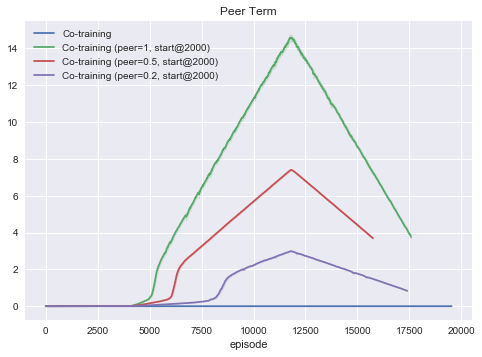

In [53]:

plot(
    {
        'path': 'logs/PongNoFrameskip-v4/copier/',
        'label': 'Co-training',
    }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1',
    #     'label': 'Co-training (peer=1)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer0dot5',
    #     'label': 'Co-training (peer=0.5)',
    # }, {
    #     'path': 'logs/PongNoFrameskip-v4/peer1_decay',
    #     'label': 'Co-training (peer=1, decay)',
    # }, {
        'path': 'logs/PongNoFrameskip-v4/peer1_start2000',
        'label': 'Co-training (peer=1, start@2000)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot5_start2000',
        'label': 'Co-training (peer=0.5, start@2000)',
    }, {
        'path': 'logs/PongNoFrameskip-v4/peer0dot2_start2000',
        'label': 'Co-training (peer=0.2, start@2000)',
    }, 
    column='peer term', title='Peer Term',
)


plotting logs/mount/BreakoutNoFrameskip-v4/individual/progress.csv
plotting logs/mount/BreakoutNoFrameskip-v4/copier/progress.csv
plotting logs/mount/BreakoutNoFrameskip-v4/peer0dot_start2000/progress.csv
plotting logs/mount/BreakoutNoFrameskip-v4/peer0dot2_start2000/progress.csv


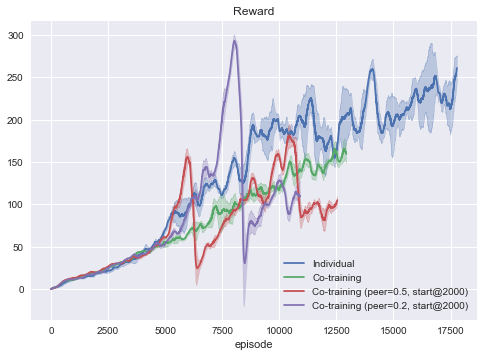

In [36]:
plot(
    {
        'path': 'logs/mount/BreakoutNoFrameskip-v4/individual/',
        'label': 'Individual'
    },
    {
        'path': 'logs/mount/BreakoutNoFrameskip-v4/copier',
        'label': 'Co-training'
    },
    {
        'path': 'logs/mount/BreakoutNoFrameskip-v4/peer0dot_start2000/',
        'label': 'Co-training (peer=0.5, start@2000)',
    },
    {
        'path': 'logs/mount/BreakoutNoFrameskip-v4/peer0dot2_start2000/',
        'label': 'Co-training (peer=0.2, start@2000)',
    },
    column='ep_reward_mean',
    title='Reward',
)

plotting logs/mount/BoxingNoFrameskip-v4/individual/progress.csv
plotting logs/mount/BoxingNoFrameskip-v4/copier/progress.csv
plotting logs/mount/BoxingNoFrameskip-v4/peer0dot5_start2000/progress.csv


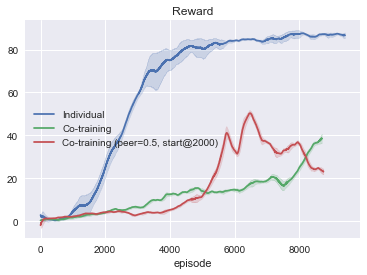

In [7]:
plot(
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/individual/',
        'label': 'Individual'
    },
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/copier',
        'label': 'Co-training'
    },
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/peer0dot5_start2000/',
        'label': 'Co-training (peer=0.5, start@2000)',
    },
    column='ep_reward_mean',
    title='Boxing',
)

plotting logs/mount/BoxingNoFrameskip-v4/2e6steps_peer0/progress.csv
plotting logs/mount/BoxingNoFrameskip-v4/2e6steps_peer1/progress.csv


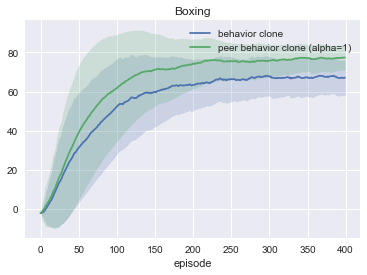

In [10]:
plot(
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/2e6steps_peer0/',
        'label': 'behavior clone'
    },
    {
        'path': 'logs/mount/BoxingNoFrameskip-v4/2e6steps_peer1/',
        'label': 'peer behavior clone (alpha=1)'
    },
    column='ep_reward_mean',
    title='Boxing',
    episodes=400,
)

In [36]:
npz = np.load('logs/mount/BoxingNoFrameskip-v4/baseline/2e6steps/expert.npz')

In [38]:
list(npz.keys())

['actions', 'obs', 'rewards', 'episode_returns', 'episode_starts']

In [40]:
npz['episode_returns']

array([55., 71., 80., 60., 69., 76., 69., 54., 82., 66., 78., 76., 82.,
       69., 75., 76., 56., 71., 73., 71., 73., 69., 58., 63., 70., 76.,
       71., 59., 71., 76., 73., 67., 84., 57., 64., 59., 71., 66., 71.,
       59., 74., 57., 69., 57., 75., 76., 56., 65., 45., 78., 67., 68.,
       75., 54., 52., 68., 88., 75., 78., 51., 64., 68., 70., 57., 61.,
       71., 60., 62., 68., 48., 75., 70., 70., 64., 71., 77., 75., 76.,
       51., 70., 75., 67., 61., 52., 60., 75., 69., 77., 71., 59., 59.,
       73., 63., 73., 65., 64., 73., 68., 69., 56.])

plotting logs/mount/FreewayNoFrameskip-v4/individual/progress.csv
plotting logs/mount/FreewayNoFrameskip-v4/copier/progress.csv
plotting logs/mount/FreewayNoFrameskip-v4/peer0dot5_start2000/progress.csv


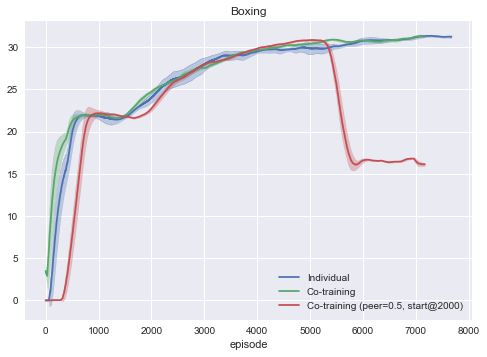

In [35]:
plot(
    {
        'path': 'logs/mount/FreewayNoFrameskip-v4/individual/',
        'label': 'Individual'
    },
    {
        'path': 'logs/mount/FreewayNoFrameskip-v4/copier',
        'label': 'Co-training'
    },
    {
        'path': 'logs/mount/FreewayNoFrameskip-v4/peer0dot5_start2000/',
        'label': 'Co-training (peer=0.5, start@2000)',
    },
    column='ep_reward_mean',
    title='Boxing',
)